In [ ]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import Sequential
from keras.layers import Dense, LSTM
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import GRU
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings('ignore')

### Build DataFrame with differeent data sources

In [3]:
data = pd.read_csv('Final AESO Data.csv', index_col = 0)
print(len(data))

27639


In [4]:
data.head()

,tmpf,relh,Avg. Price,Avg. Gas Price,System Load,Total Outage,Total Gen
2019-01-01 00:00:00,14.36,64.748000,32.90,1.49,7112,1102,363.74
2019-01-01 01:00:00,15.50,73.786667,32.78,1.49,6980,1100,363.97
2019-01-01 02:00:00,17.60,78.325556,32.78,1.49,6840,1100,363.97
2019-01-01 03:00:00,19.40,80.454000,32.78,1.49,6691,1100,363.97
2019-01-01 04:00:00,19.40,79.160000,32.13,1.49,6649,1105,363.62


In [5]:
steps=24
dataset_for_prediction= data.copy()
dataset_for_prediction['Actual']=dataset_for_prediction['Avg. Price'].shift(-steps)
dataset_for_prediction=dataset_for_prediction.dropna()

In [6]:
sc_in = MinMaxScaler(feature_range=(0, 1))
scaled_input = sc_in.fit_transform(dataset_for_prediction)
scaled_input =pd.DataFrame(scaled_input)
X= scaled_input

sc_out = MinMaxScaler(feature_range=(0, 1))
scaler_output = sc_out.fit_transform(dataset_for_prediction[['Actual']])
scaler_output =pd.DataFrame(scaler_output)
y = scaler_output
#list(dataset_for_prediction.columns)

In [7]:
X.rename(columns = {0:'tmpf',
                    1:'relh',
                    2:'Avg. Price',
                    3:'Avg. Gas Price',
                    4:'System Load',
                    5:'Total Outage',
                    6:'Total Gen',
                    7:'Actual'}, inplace = True)

In [8]:
X.index = dataset_for_prediction.index
X.drop(columns = 'Actual', inplace = True)

y.rename(columns={0:'Electricity price in 24 hours'}, inplace= True)
y.index=dataset_for_prediction.index

In [9]:
train_X, train_y = X[24:26280], y[24:26280] 
test_X, test_y = X[26280:].dropna(), y[26280:].dropna()

In [10]:
test_X.head(1)

,tmpf,relh,Avg. Price,Avg. Gas Price,System Load,Total Outage,Total Gen
2021-12-31 00:00:00,0.106667,0.54624,0.085051,0.697531,0.617969,0.287461,0.677525


In [11]:
from statsmodels.tsa.stattools import adfuller

def test_adf(series, title=''):
    dfout={}
    dftest=sm.tsa.adfuller(series.dropna(), autolag='AIC', regression='ct')
    for key,val in dftest[4].items():
        dfout['critical value {}'.format(key)]=val
    if dftest[1]<=0.05:
        print("Strong evidence against Null Hypothesis")
        print("Reject Null Hypothesis - Data is Stationary")
        print("Data is Stationary", title)
    else:
        print("Strong evidence for  Null Hypothesis")
        print("Accept Null Hypothesis - Data is not Stationary")
        print("Data is NOT Stationary for", title)
        
y_test=y['Electricity price in 24 hours'][24:17520].dropna()
test_adf(y_test, "Electricity Price")

Strong evidence against Null Hypothesis
Reject Null Hypothesis - Data is Stationary
Data is Stationary Electricity Price


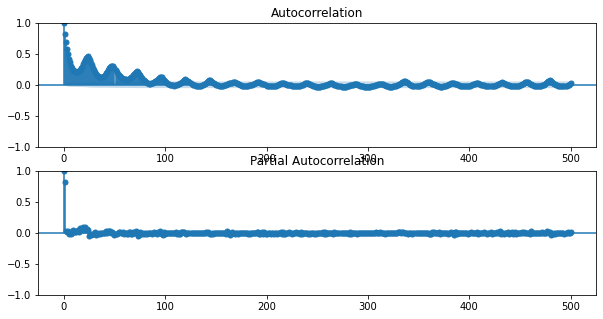

In [12]:
fig,ax= plt.subplots(2,1, figsize=(10,5))
fig=sm.tsa.graphics.plot_acf(y_test, lags=500, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(y_test, lags=500, ax=ax[1])
plt.show()

In [13]:
 step_wise = auto_arima(train_y, 
     exogenous= train_X,
     start_p=0, start_q=0, 
     max_p=5, max_q=5, 
     d=1, max_d=168,
     n_jobs = -1,
     start_Q=0,
     max_P=5,
     max_D=5,
     max_Q=5,
     seasonal = True,
     stationary = True,
     trace=True, 
     error_action='ignore', 
     suppress_warnings=True, 
     random = True,
     stepwise=False)


Best model:  ARIMA(4,0,1)(0,0,0)[1] intercept
Total fit time: 75.712 seconds


In [14]:
step_wise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                26256
Model:               SARIMAX(4, 0, 1)   Log Likelihood               37075.669
Date:                Fri, 25 Mar 2022   AIC                         -74123.337
Time:                        19:54:09   BIC                         -74008.878
Sample:                    01-02-2019   HQIC                        -74086.378
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -0.0189      0.004     -4.859      0.000      -0.027      -0.011
tmpf               0.0200      0.009      2.118      0.034       0.001       0.038
relh              -0.0165      0.006     -2.865      0.004      -0.028      -0.005
Avg. Price         0.1291      0.003     43.994      0.000       0.123       0.135
Avg. Gas Price     0.0649      0.012      5.353      0.000       0.041       0.089
System Load        0.1439      0.009     15.295      0.000       0.125       0.162
Total Outage       0.0358      0.009      3.804      0.000       0.017       0.054
Total Gen          0.0488      0.011      4.411      0.000       0.027       0.071
ar.L1              0.4909      0.151      3.262      0.001       0.196       0.786
ar.L2              0.2611      0.125      2.084      0.037       0.016       0.507
ar.L3             -0.0208      0.004     -5.569      0.000      -0.028      -0.013
ar.L4              0.0155      0.003      5.950      0.000       0.010       0.021
ma.L1              0.3425      0.151      2.274      0.023       0.047       0.638
sigma2             0.0035   9.58e-06    362.578      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1764289.49
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.46   Skew:                             2.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
model= SARIMAX(train_y, 
 exog=train_X,
 order=(4,0,1),
enforce_invertibility=False, enforce_stationarity=False)

In [16]:
len(test_X)

1335

In [17]:
results=model.fit()

forecast = results.forecast(steps=1335, exog = test_X)

In [18]:
steps = -24
predictions= results.predict(start = 26280, end=27615+(steps)-1 ,exog=test_X)

In [19]:
forecast_electricity= pd.DataFrame(forecast)
forecast_electricity.reset_index(drop=True, inplace=True)
forecast_electricity.index=test_X.index
forecast_electricity['Actual'] = scaler_output.iloc[17520:, 0]

In [20]:
forecast_electricity

,predicted_mean,Actual
2021-12-31 00:00:00,0.077430,0.065641
2021-12-31 01:00:00,0.080978,0.061591
2021-12-31 02:00:00,0.085205,0.056671
2021-12-31 03:00:00,0.091530,0.045580
2021-12-31 04:00:00,0.100179,0.057391
...,...,...
2022-02-24 10:00:00,0.125779,0.065221
2022-02-24 11:00:00,0.114842,0.075821
2022-02-24 12:00:00,0.122602,0.074121
2022-02-24 13:00:00,0.121940,0.069111


<AxesSubplot:>

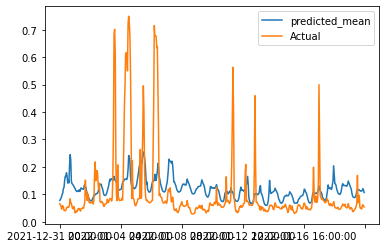

In [21]:
forecast_electricity['predicted_mean'][:500].plot(legend=True)
forecast_electricity['Actual'][:500].plot(legend=True)

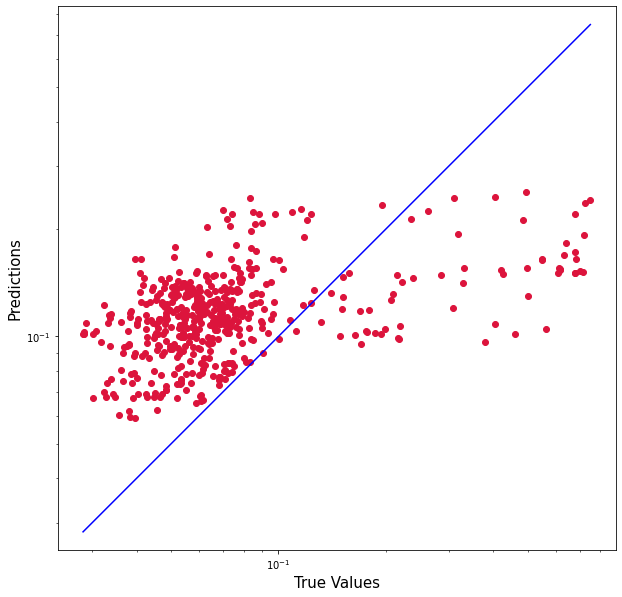

In [32]:
plt.figure(figsize=(10,10))
plt.scatter(forecast_electricity['Actual'][:500], forecast_electricity['predicted_mean'][:500], c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(forecast_electricity['predicted_mean'][:500].values[:500]), max(forecast_electricity['Actual'][:500].values[:500]))
p2 = min(min(forecast_electricity['predicted_mean'][:500].values[:500]), min(forecast_electricity['Actual'][:500].values[:500]))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [22]:
from numpy import inf

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    difference = abs((y_true - y_pred))
    difference[difference == inf] = 0.01
    difference[difference == -inf] = 0.01
    difference[difference == 0] = 0.01
    y_true[y_true == 0] = 0.01
    return np.mean((difference/y_true) * 100)

In [23]:
mape = mean_absolute_percentage_error(forecast_electricity['Actual'], forecast_electricity['predicted_mean'])
mape

89.18850956658495

In [24]:
act= pd.DataFrame(scaler_output.iloc[26280:, 0])
act.head()

,Electricity price in 24 hours
2021-12-31 00:00:00,0.065641
2021-12-31 01:00:00,0.061591
2021-12-31 02:00:00,0.056671
2021-12-31 03:00:00,0.045580
2021-12-31 04:00:00,0.057391


In [25]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X[24:].index
predictions=pd.DataFrame(predictions)
predictions['Actual'] = act['Electricity price in 24 hours']
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)

In [26]:
testPredict = sc_out.inverse_transform(predictions[['Pred']])
testActual = sc_out.inverse_transform(predictions[['Actual']])

In [27]:
unscaled = pd.DataFrame(testPredict)
unscaled['actual'] = testActual
unscaled = unscaled.rename(columns={0: 'predictions'})

<AxesSubplot:>

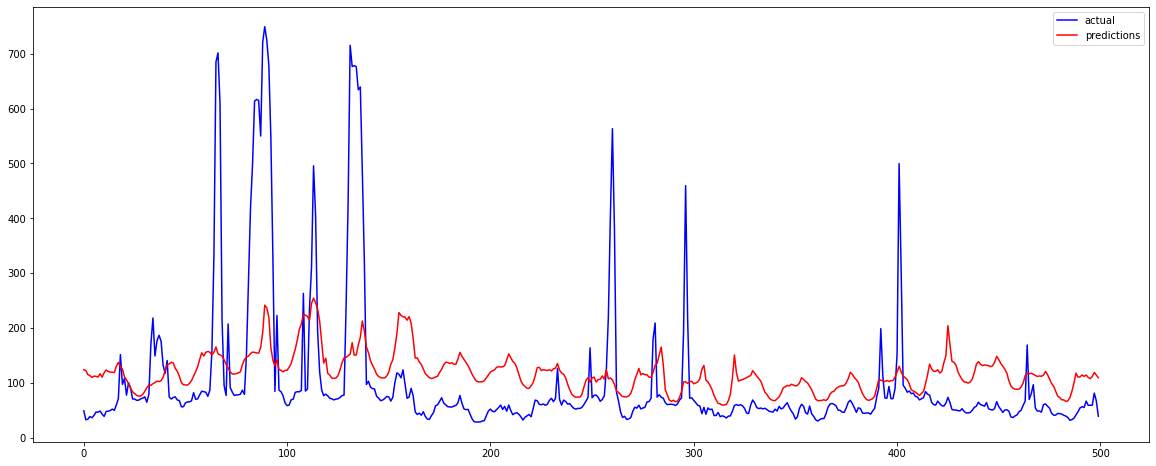

In [28]:
unscaled['actual'][:500].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'][:500].plot(legend=True, color='red', figsize=(20,8))

<AxesSubplot:>

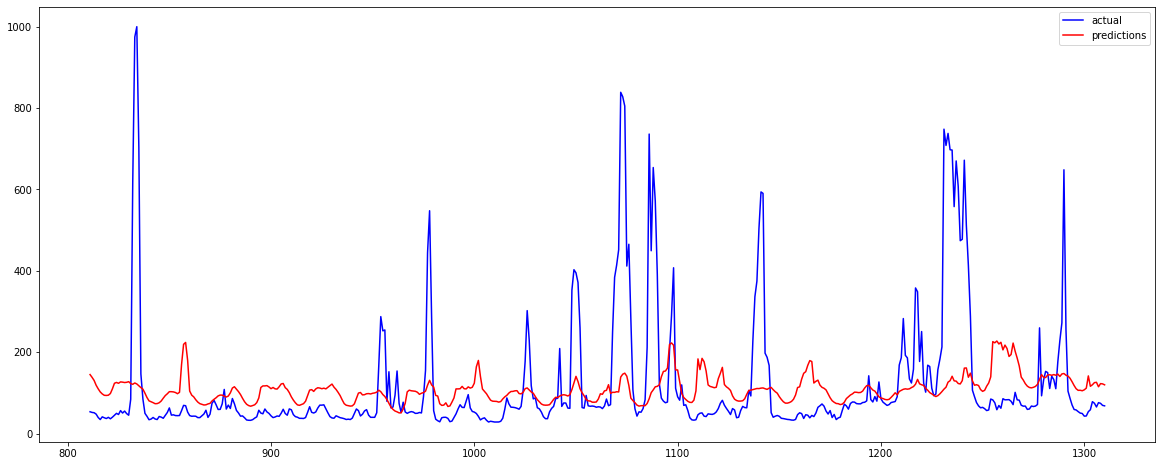

In [29]:
unscaled['actual'][-500:].plot(figsize=(20,8), legend=True, color='blue')
unscaled['predictions'][-500:].plot(legend=True, color='red', figsize=(20,8))

In [30]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

In [31]:
from sklearn.model_selection import GridSearchCV
xgb1 = xgb.XGBRegressor()
parameters = { #when use hyperthread, xgboost may become slower
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07], #so called `eta` value
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [100,500, 1000],
             'n_jobs' : [-1]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(train_X,
         train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


KeyboardInterrupt: 

In [48]:
xgbbest = xgb.XGBRegressor(min_child_weight = 4, max_depth = 6, n_estimators = 100, learning_rate=0.05, colsample_bytree =0.7, n_jobs = -1, silent = 1 , subsample = 0.7)
xgbbest.fit(train_X, train_y)

train Error with POS =  0.014426966710059481
test Error with POS =  0.03050623917117645


### ARIMA Model

In [49]:
y = pd.DataFrame(cp.deepcopy(train_y))

In [50]:
station_y = []
for i in range(1,len(y)):
    station_y.append(y.iloc[i-1]- y.iloc[i])

station_y = pd.DataFrame(station_y)
y = station_y

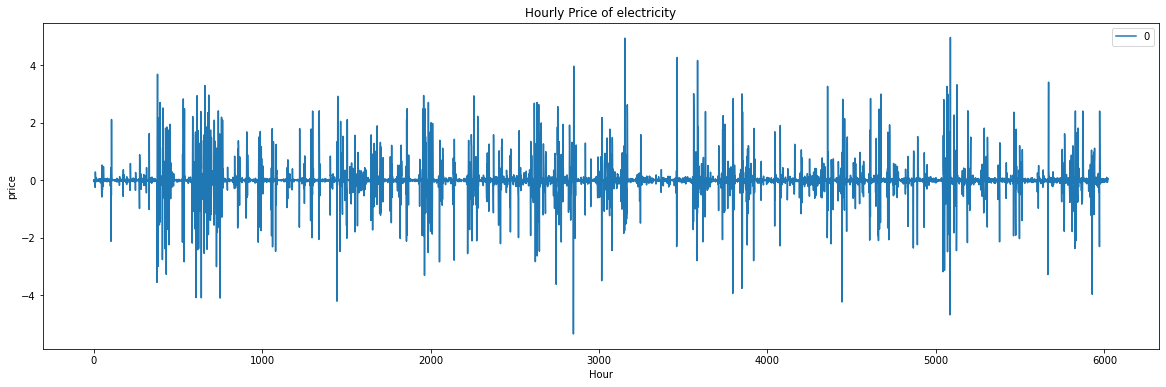

In [52]:
y.plot(figsize=(20, 6))
plt.xlabel('Hour')
plt.ylabel('price')
plt.title('Hourly Price of electricity')
plt.show()

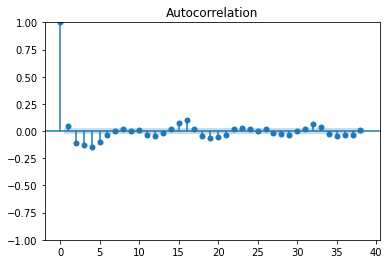

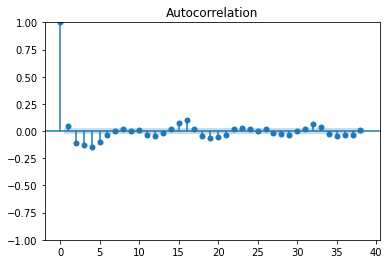

In [54]:
plot_acf(y)

In [55]:
# Test for Stationarity

from statsmodels.tsa.stattools import adfuller
X = y.values
X = X.flatten()
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -18.238192
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [58]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 15) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 15)
SARIMAX: (0, 0, 1) x (0, 1, 0, 15)
SARIMAX: (0, 1, 0) x (0, 1, 1, 15)
SARIMAX: (0, 1, 0) x (1, 0, 0, 15)


In [59]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 15)12 - AIC:10589.647481913536
ARIMA(0, 0, 0)x(0, 0, 1, 15)12 - AIC:10546.945954081919
ARIMA(0, 0, 0)x(0, 1, 0, 15)12 - AIC:14282.058493082317
ARIMA(0, 0, 0)x(0, 1, 1, 15)12 - AIC:10619.721605452709
ARIMA(0, 0, 0)x(1, 0, 0, 15)12 - AIC:10547.743247514352
ARIMA(0, 0, 0)x(1, 0, 1, 15)12 - AIC:10548.855575456038
ARIMA(0, 0, 0)x(1, 1, 0, 15)12 - AIC:12840.832782232796
ARIMA(0, 0, 0)x(1, 1, 1, 15)12 - AIC:10602.136952481025
ARIMA(0, 0, 1)x(0, 0, 0, 15)12 - AIC:10576.545631922952
ARIMA(0, 0, 1)x(0, 0, 1, 15)12 - AIC:10538.744228940475
ARIMA(0, 0, 1)x(0, 1, 0, 15)12 - AIC:14280.057162001405
ARIMA(0, 0, 1)x(0, 1, 1, 15)12 - AIC:10607.186087533468
ARIMA(0, 0, 1)x(1, 0, 0, 15)12 - AIC:10540.252297190767
ARIMA(0, 0, 1)x(1, 0, 1, 15)12 - AIC:10540.654888862256
ARIMA(0, 0, 1)x(1, 1, 0, 15)12 - AIC:12838.112020920675
ARIMA(0, 0, 1)x(1, 1, 1, 15)12 - AIC:10593.341018190764
ARIMA(0, 1, 0)x(0, 0, 0, 15)12 - AIC:14496.717590096847
ARIMA(0, 1, 0)x(0, 0, 1, 15)12 - AIC:14475.75344

In [60]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8170      0.005    176.597      0.000       0.808       0.826
ma.L1         -1.0076      0.002   -648.149      0.000      -1.011      -1.005
ar.S.L12     -2.5e-05      0.010     -0.002      0.998      -0.020       0.020
ma.S.L12      -1.0032      0.003   -312.945      0.000      -1.009      -0.997
sigma2         0.3058      0.003    114.339      0.000       0.301       0.311


In [66]:
pred = results.predict(start=4799)

In [67]:
pred = np.array(pred)
pred.flatten().shape

(1225,)

In [68]:
#RESULTS OF ARIMA

print('r2 score=',r2_score(pred,Y_test))
print('MSE score=',mean_squared_error(pred,Y_test))
print('MAE score=',mean_absolute_error(pred,Y_test))

r2 score= -24.40978908626058
MSE score= 0.8164017261166064
MAE score= 0.5317650513140527


### Combining ARIMA and EML

In [69]:
pred2 = np.array(eml_fit2).flatten()
pred2.shape

(1225,)

In [70]:
res = (pred + pred2)/2

In [71]:
print('r2 score=',r2_score(res,Y_test))
print('MSE Error=',mean_squared_error(res,Y_test))
print('MAE Error=',mean_absolute_error(res,Y_test))

r2 score= -7.180227192863958
MSE Error= 0.9734475019667396
MAE Error= 0.6883477920843325
